##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 15 - Missing Data and Other Opportunities


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/15_missing_data_and_other_opportunities"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/15_missing_data_and_other_opportunities.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/15_missing_data_and_other_opportunities.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/15_missing_data_and_other_opportunities.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions


In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [4]:
#@title Install { display-mode: "form" }

# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Installing arviz ...")
    !pip install -q arviz

In [5]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [6]:
az.style.use('seaborn-colorblind')

## Tensorflow MCMC Sampling helpers

In [7]:
USE_XLA = False              #@param

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )


In [8]:
NUMBER_OF_SAMPLES = 2000           #@param

MCMC_NUMBER_OF_CHAINS  = 2         #@param 
MCMC_NUMBER_OF_BURNIN  = 1000      #@param
MCMC_NUMBER_OF_LEAPFROG_STEPS = 4  #@param

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=MCMC_NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=MCMC_NUMBER_OF_BURNIN):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
    )         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors,
    )       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(
              jdc, 
              observed_data,
              init_config,
              mcmc_config=dict(),
              num_samples=NUMBER_OF_SAMPLES):
    
    assert init_config is not None
    
    # expecting the order of keys is same 
    # as that of definition in the model function
    params = init_config.keys()
    
    init_state = []
    bijectors = []
    for p in params:
        init_state.append(init_config[p]['state'])
        bijectors.append(init_config[p]['bijector'])

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  
    
    
    step_size  = mcmc_config.get('step_size', 0.1)
    num_chains = mcmc_config.get('num_chains', MCMC_NUMBER_OF_CHAINS)
    burnin     = mcmc_config.get('burnin', MCMC_NUMBER_OF_BURNIN)
    
    results, sample_stats = run_hmc_chain(
        init_state,
        bijectors,
        step_size=step_size,
        target_log_prob_fn=target_log_prob_fn,                                      
        num_samples=num_samples, 
        burnin=burnin,
    )

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

    return posterior, az_trace

## Dataset URLs & Utils


In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"

In [10]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns,dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields) 

# Introduction

##### Code 15.1

In [11]:
# simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = tfd.Categorical(logits=np.ones(3)).sample().numpy()
    sides = np.array([1, 1, 1, 0, 0, 0]).reshape(3, 2).T[:, pancake]
    np.random.shuffle(sides)
    return sides

# sim 10,000 pancakes
pancakes = []
for i in range(10_000):
    pancakes.append(sim_pancake())
    
pancakes = np.array(pancakes).T

up = pancakes[0]
down = pancakes[1]

# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up == 1)
num_11 = np.sum((up == 1) & (down == 1))
num_11 / num_11_10

0.6765178930438279

## 15.1 Measurement error

##### Code 15.2

In the waffle dataset, both divorce rate and marriage rate variables are measured with substantial error and that error is reported in the form of standard errors.

Also error varies across the states. 

Below we are plotting the measurement errors

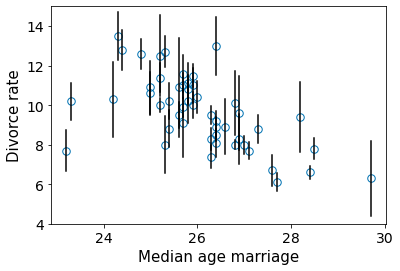

In [12]:
d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")

# points
ax = az.plot_pair(d[["MedianAgeMarriage", "Divorce"]].to_dict(orient="list"),
                  scatter_kwargs=dict(ms=15, mfc="none"))
ax.set(ylim=(4, 15), xlabel="Median age marriage", ylabel="Divorce rate")

# standard errors
for i in range(d.shape[0]):
    ci = d.Divorce[i] + np.array([-1, 1]) * d["Divorce SE"][i]
    x = d.MedianAgeMarriage[i]
    plt.plot([x, x], ci, "k")
    
    

In the above plot, the lenght of the vertical lines show how uncertain the observed divorce rate is.

### 15.1.1 Error on the outcome

##### Code 15.3

In [13]:
d["D_obs"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values
d["D_sd"]  = d["Divorce SE"].values / d.Divorce.std()
d["M"]     = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values
d["A"]     = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values

N = d.shape[0]

tdf = df_to_tensors("Waffle", d, ["D_obs", "D_sd", "M", "A"])

def model_15_1(A, M, D_sd, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))  
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
        
      mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A + betaM[...,tf.newaxis] * M    
    
      scale = sigma[...,tf.newaxis]
     
      D_true = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)    
      D_obs = yield tfd.Independent(tfd.Normal(loc=D_true, scale=D_sd), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_1 = model_15_1(tdf.A, tdf.M, tdf.D_sd, N)


In [14]:
init_state = [
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS, N]),
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    betaA  = dict(state=init_state[1], bijector=tfb.Identity()),
    betaM  = dict(state=init_state[2], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[3], bijector=tfb.Exp()),
    D_true = dict(state=init_state[4], bijector=tfb.Identity()),
)

posterior_15_1, trace_15_1 = sample_posterior(jdc_15_1,
                               init_config=init_config,
                               observed_data=(tdf.D_obs,))

Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.


##### Code 15.4

In [15]:
az.summary(trace_15_1, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.06,0.09,-0.23,0.07,0.00,0.00,364.88,364.88,366.19,623.87,1.00
betaA,-0.61,0.16,-0.88,-0.36,0.01,0.01,308.90,285.84,307.13,439.61,1.00
betaM,0.05,0.16,-0.20,0.30,0.01,0.01,251.95,251.95,253.34,645.79,1.01
sigma,0.58,0.10,0.41,0.73,0.01,0.00,223.90,223.90,217.81,363.35,1.01
D_true[0],1.16,0.36,0.55,1.67,0.02,0.01,440.83,440.83,443.51,1113.24,1.00
D_true[1],0.62,0.57,-0.30,1.51,0.04,0.03,237.54,237.54,237.22,561.87,1.01
D_true[2],0.43,0.34,-0.07,0.97,0.01,0.01,660.60,660.60,661.22,1124.49,1.00
D_true[3],1.43,0.46,0.75,2.18,0.03,0.02,303.99,303.99,304.73,517.54,1.01
D_true[4],-0.90,0.14,-1.14,-0.71,0.00,0.00,2972.04,2838.17,3015.24,581.55,1.00
D_true[5],0.67,0.40,0.05,1.30,0.02,0.01,422.95,422.95,423.01,613.09,1.00


##### Code 15.5

What happens when there is a measurement error on predictor variables as well ?

In [16]:
d["D_obs"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std()).values
d["D_sd"]  = d["Divorce SE"].values / d.Divorce.std()
d["M_obs"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std()).values
d["M_sd"]  = d["Marriage SE"].values / d.Marriage.std()
d["A"]     = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std()).values

N = d.shape[0]

tdf = df_to_tensors("Waffle", d, ["D_obs", "D_sd", "M_obs", "M_sd", "A"])

def model_15_2(A, M_sd, D_sd, N):
    def _generator():      
      alpha  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM  = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))  
      sigma  = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        
      M_true = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="M_true"), sample_shape=N))        
        
      mu = alpha[...,tf.newaxis] + betaA[...,tf.newaxis] * A + betaM[...,tf.newaxis] * M_true    
    
      scale = sigma[...,tf.newaxis]
     
      D_true = yield tfd.Independent(tfd.Normal(loc=mu, scale=scale), reinterpreted_batch_ndims=1)    
      D_obs  = yield tfd.Independent(tfd.Normal(loc=D_true, scale=D_sd), reinterpreted_batch_ndims=1)
      M_obs  = yield tfd.Independent(tfd.Normal(loc=M_true, scale=M_sd, name="M_obs"), reinterpreted_batch_ndims=1)    
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_2 = model_15_2(tdf.A, tdf.M_sd, tdf.D_sd, N)


In [17]:
init_state = [
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS]),
    tf.ones([MCMC_NUMBER_OF_CHAINS]),
    tf.zeros([MCMC_NUMBER_OF_CHAINS, N]),  # M_True
    tf.zeros([MCMC_NUMBER_OF_CHAINS, N]),  # D_True
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    betaA  = dict(state=init_state[1], bijector=tfb.Identity()),
    betaM  = dict(state=init_state[2], bijector=tfb.Identity()),
    sigma  = dict(state=init_state[3], bijector=tfb.Exp()),
    M_true = dict(state=init_state[4], bijector=tfb.Identity()),
    D_true = dict(state=init_state[4], bijector=tfb.Identity()),
)


posterior_15_2, trace_15_2 = sample_posterior(jdc_15_2,
                                   init_config=init_config,
                                   observed_data=(tdf.D_obs, tdf.M_obs))

##### Code 15.6

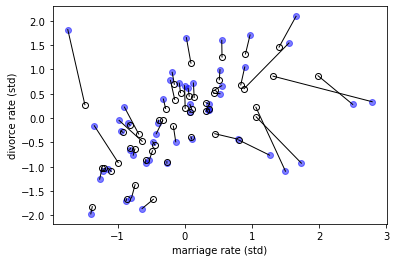

In [18]:
post_D_true = trace_15_2.posterior["D_true"].values[0]
post_M_true = trace_15_2.posterior["M_true"].values[0]

D_est = np.mean(post_D_true, 0)
M_est = np.mean(post_M_true, 0)
plt.plot(d["M_obs"], d["D_obs"], "bo", alpha=0.5)
plt.gca().set(xlabel="marriage rate (std)", ylabel="divorce rate (std)")
plt.plot(M_est, D_est, "ko", mfc="none")
for i in range(d.shape[0]):
    plt.plot([d["M_obs"][i], M_est[i]], [d["D_obs"][i], D_est[i]],
             "k-", lw=1)

Above figure demonstrates shrinkage of both divorce rate and marriage rate. Solid points are the observed values. Open points are posterior means. Lines connect pairs of points for the same state. Both variables are shrunk towards the inferred regression relationship.

With measurement error, the insight is to realize that any uncertain piece of data can be replaced by a distribution that reflects uncertainty.

##### Code 15.7

In [19]:
# Simulated toy data

N = 500
A = tfd.Normal(loc=0., scale=1.0).sample((N,))
M = tfd.Normal(loc=-A, scale=1.0).sample()
D = tfd.Normal(loc=A, scale=1.0).sample()
A_obs = tfd.Normal(loc=A, scale=1.).sample()

## 15.2 Missing data

### 15.2.1 DAG ate my homework

##### Code 15.8

In [20]:
N = 100
S = tfd.Normal(loc=0., scale=1.).sample((N,))
H = tfd.Binomial(total_count=10, probs=tf.sigmoid(S)).sample()

##### Code 15.9

Hm = Homework missing

Dog's decision to eat a piece of homework or not is not influenced by any relevant variable

In [21]:
D = tfd.Bernoulli(0.5).sample().numpy()  # dogs completely random
Hm = np.where(D == 1, np.nan, H)

Hm

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

Since missing values are random, missignness does not necessiarily change the overall distribution of homework score.

##### Code 15.10

Here studying influences whether a dog eats homework S->D

Students who study a lot do not play with their Dogs and then dogs take revenge by eating homework


In [22]:
D = np.where(S > 0, 1, 0)
Hm = np.where(D == 1, np.nan, H)

Hm

array([nan,  3., nan,  0.,  3.,  2.,  5.,  3.,  0.,  6., nan,  6., nan,
        0., nan,  1., nan, nan,  1.,  5.,  1., nan,  5.,  3.,  2., nan,
       nan, nan,  5.,  2., nan, nan,  5.,  8., nan, nan,  4.,  1., nan,
        3., nan, nan,  2.,  4.,  3.,  3., nan, nan,  5., nan, nan,  5.,
       nan, nan, nan,  4.,  4.,  4., nan, nan,  2., nan,  3., nan,  3.,
        0.,  3.,  5.,  4., nan,  2., nan,  3.,  2.,  2.,  4., nan,  1.,
       nan, nan,  5., nan,  1.,  3.,  2.,  3., nan,  4.,  1.,  3., nan,
       nan, nan,  1.,  3., nan, nan,  4.,  4.,  4.], dtype=float32)

Now every student who studies more than average (0) is missing homework

##### Code 15.11

The case of noisy home and its influence on homework & Dog's behavior

In [23]:
# TODO - use seed; have not been able to make it work with tfp

N = 1000
X = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=(N,)).sample().numpy()
S = tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=(N,)).sample().numpy()

logits = 2 + S - 2 * X

H = tfd.Binomial(total_count=10, logits=logits).sample().numpy()

D = np.where(X > 1, 1, 0)
Hm = np.where(D == 1, np.nan, H)

##### Code 15.12

In [24]:
tdf = df_to_tensors("SimulatedHomeWork", pd.DataFrame.from_dict(dict(H=H,S=S)), ["H", "S"])

def model_15_3(S):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="alpha"), sample_shape=1))
      betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaS"), sample_shape=1))
              
      logits = tf.squeeze(alpha[...,tf.newaxis] + betaS[...,tf.newaxis] * S)      
      
      H = yield tfd.Independent(tfd.Binomial(total_count=10, logits=logits), reinterpreted_batch_ndims=1)    
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_3 = model_15_3(tdf.S)

In [25]:
NUM_CHAINS_FOR_15_3 = 4

alpha_init, betaS_init, _ = jdc_15_3.sample()

init_state = [
    tf.tile(alpha_init, (MCMC_NUMBER_OF_CHAINS,)),
    tf.tile(betaS_init, (MCMC_NUMBER_OF_CHAINS,))    
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    betaS  = dict(state=init_state[1], bijector=tfb.Identity())
)



posterior_15_3, trace_15_3 = sample_posterior(jdc_15_3,
                               init_config=init_config,
                               observed_data=(tdf.H,))

In [26]:
az.summary(trace_15_3, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.27,0.03,1.24,1.32,0.01,0.01,5.31,5.31,5.36,43.21,1.29
betaS,0.65,0.03,0.61,0.70,0.01,0.01,5.12,5.12,5.16,34.06,1.31


The true coefficient on S should be 1.00. We don’t expect to get that exactly, but the estimate above is way off

##### Code 15.13

We build the model with missing data now

In [27]:
tdf = df_to_tensors("SimulatedHomeWork", 
                    pd.DataFrame.from_dict(dict(H=H[D==0],S=S[D==0])), ["H", "S"])

def model_15_4(S):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="alpha"), sample_shape=1))
      betaS = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaS"), sample_shape=1))
              
      logits = tf.squeeze(alpha[...,tf.newaxis] + betaS[...,tf.newaxis] * S)      
      
      H = yield tfd.Independent(tfd.Binomial(total_count=10, logits=logits), reinterpreted_batch_ndims=1)    
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_15_4 = model_15_4(tdf.S)

In [28]:
alpha_init, betaS_init, _ = jdc_15_4.sample()

init_state = [
    tf.tile(alpha_init, (MCMC_NUMBER_OF_CHAINS,)),
    tf.tile(betaS_init, (MCMC_NUMBER_OF_CHAINS,))    
]

init_config = dict(
    alpha  = dict(state=init_state[0], bijector=tfb.Identity()),
    betaS  = dict(state=init_state[1], bijector=tfb.Identity())
)


posterior_15_4, trace_15_4 = sample_posterior(jdc_15_4,
                               init_config=init_config,
                               observed_data=(tdf.H,))

In [29]:
az.summary(trace_15_4, round_to=2, kind='all', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.97,0.04,1.92,2.03,0.0,0.0,2749.35,2704.99,2787.27,980.60,1.0
betaS,0.86,0.03,0.81,0.92,0.0,0.0,1804.96,1707.50,1823.20,859.78,1.0


##### Code 15.14

In [30]:
D = np.where(np.abs(X) < 1, 1, 0)

##### Code 15.15

In [31]:
N = 100
S = tfd.Normal(loc=0., scale=1.).sample((N,))
H = tfd.Binomial(total_count=10, logits=S).sample().numpy()
D = np.where(H < 5, 1, 0)
Hm = np.where(D == 1, np.nan, H)

Hm

array([nan,  7., nan,  8.,  5.,  6.,  8., nan,  6., nan,  7., nan,  6.,
       nan,  9., nan, nan, nan, nan,  8., nan, nan,  6., nan, nan,  8.,
        8., 10.,  5.,  5.,  7., nan,  5.,  5., nan,  9.,  6.,  8.,  8.,
       nan, 10., nan,  7., nan,  6., nan, nan, nan,  6.,  5., nan, nan,
       nan,  7., nan,  9.,  8.,  8.,  8., nan, nan,  6.,  8., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan,  7., nan, nan, nan,  5.,
        7., nan,  8.,  7.,  7., 10.,  8.,  7., nan,  8., nan, nan,  8.,
        6., nan, nan,  9.,  6.,  8., nan, nan, nan], dtype=float32)

## 15.3 Categorical errors and discrete absences (TODO)